In [1]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
batch_size = 8
epochs = 10

In [3]:
import random
seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in polarity_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)} \t {round(len(y_preds[y_preds==label])/len(y_true),2)}\n')
        
        
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

def predict(dataloader, num_classes):

    model.eval()
    
    predictions = []
    total_score=[0]*num_classes
    for batch in dataloader:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
        }

        with torch.no_grad():        
            outputs = model(**inputs)
            scores=torch.max(torch.nn.Softmax(dim=1)(outputs[0]),axis=1)
            for i,x in enumerate(scores[0]):
                ind=int(scores[1][i])
                predictions.append((ind,round(float(x),4)))
                total_score[ind] +=x
    return predictions, total_score
    
def evaluate_single(sentense):

    model.eval()
    
    loss_val_total = 0
    encoded_data_test = tokenizer.batch_encode_plus(
    [sentense], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
    )
    encoded_data_test.to(device)
    with torch.no_grad():        
        outputs = model(**encoded_data_test)
    return outputs

In [6]:
df = pd.read_csv('data/polarity3_data/twitter_polarity3.csv', encoding='latin-1')
#df.set_index('id', inplace=True)
df.head()

,text,sentiment
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,positive
1,Reading my kindle2... Love it... Lee childs i...,positive
2,"Ok, first assesment of the #kindle2 ...it fuck...",positive
3,@kenburbary You'll love your Kindle2. I've had...,positive
4,@mikefish Fair enough. But i have the Kindle2...,positive


In [7]:
#df=df.sample(n=10000,axis=0)
df.shape

(498, 2)

In [8]:
polarity_dict={'positive':0, 'negative':1, 'neutral':2}
df['label'] = df.sentiment.replace(polarity_dict)

In [9]:
df

,text,sentiment,label
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,positive,0
1,Reading my kindle2... Love it... Lee childs i...,positive,0
2,"Ok, first assesment of the #kindle2 ...it fuck...",positive,0
3,@kenburbary You'll love your Kindle2. I've had...,positive,0
4,@mikefish Fair enough. But i have the Kindle2...,positive,0
...,...,...,...
493,Ask Programming: LaTeX or InDesign?: submitted...,neutral,2
494,"On that note, I hate Word. I hate Pages. I hat...",negative,1
495,Ahhh... back in a *real* text editing environm...,positive,0
496,"Trouble in Iran, I see. Hmm. Iran. Iran so far...",negative,1


In [10]:
X_train, X_val, y_train, y_val = train_test_split(df.text.values, 
                                                  df.label.values, 
                                                  test_size=0.10, 
                                                  random_state=1, 
                                                  stratify=df.label.values)


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    X_train, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=300, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=300, 
    return_tensors='pt'
)

In [12]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(polarity_dict),
                                                      output_attentions=True,
                                                      output_hidden_states=False)


dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)
model.to(device)

pass

In [ ]:
if not os.path.isdir('checkpoints') os.mkdir('checkpoints')

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    
    torch.save(model.state_dict(), f'checkpoints/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

In [15]:
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()
report=classification_report(labels_flat, preds_flat, target_names=polarity_dict.keys())
print(report)

Class: positive
Accuracy: 16/18 	 0.89

Class: negative
Accuracy: 14/18 	 0.78

Class: neutral
Accuracy: 11/14 	 0.79

              precision    recall  f1-score   support

    positive       0.73      0.89      0.80        18
    negative       0.93      0.78      0.85        18
     neutral       0.85      0.79      0.81        14

    accuracy                           0.82        50
   macro avg       0.84      0.82      0.82        50
weighted avg       0.83      0.82      0.82        50



In [ ]:
report

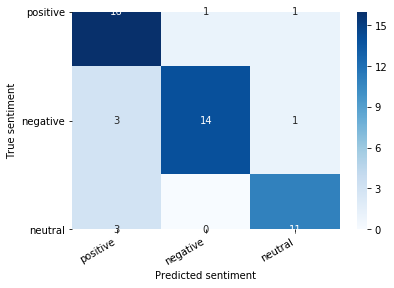

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(labels_flat, preds_flat)
df_cm = pd.DataFrame(cm, index=polarity_dict.keys(), columns=polarity_dict.keys())
show_confusion_matrix(df_cm)

In [ ]:
import gc
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def reset_gpu():
    try:
        del encoded_data_test
    except:
        pass
    try:
        del tokenizer
    except:
        pass
    try:
        del output
    except:
        pass
    try:
        del scores, dic
    except:
        pass
    torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(), torch.cuda.memory_reserved())
gc.collect()
reset_gpu()
print(torch.cuda.memory_allocated(), torch.cuda.memory_reserved())

In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=3,
                                                      output_attentions=True,
                                                      output_hidden_states=True)
model.to(device)
model.load_state_dict(torch.load('notebook_data/finetuned_BERT_epoch_10.model', map_location=torch.device('cuda')))
print(torch.cuda.memory_allocated(), torch.cuda.memory_reserved())
#reset_gpu()
#print(torch.cuda.memory_allocated(), torch.cuda.memory_reserved())
model.eval()

878142464 1438646272


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
inputs=['Imagine all the people sharing all the world',
        'I love this restaurant but the line is too long',
        'we should be making a profit by this time next year.',
        'She earned her PhD in physics before becoming a postdoctoral fellow at Rockefeller University, where she worked on developing and implementing an underwater touchscreen for dolphins.',
        'I did smile today!',
        'Applies the Softmax function to an n-dimensional input Tensor', 
        'I have not slept enough today', 
        'the weather is crazy hot today',
        'Listen Morty, I hate to break it to you, but what people call “love” is just a chemical reaction that compels animals to breed. It hits hard, Morty, then it slowly fades, leaving you stranded in a failing marriage. I did it. Your parents are gonna do it. Break the cycle, Morty. Rise above. Focus on science.',
        'I am a scientist, because I invent, transform, create, and destroy for a living, and when I do not like something about the world, I change it',
        'I turned myself into a pickle, Morty! I’m Pickle Rick!',
        'Do you wanna develop an app?',
        'Honey, stop raising your father cholesterol so you can take a hot funeral selfie.',
        'To live is to risk it all; otherwise you are just an inert chunk of randomly assembled molecules drifting wherever the universe blows you...'
        ]

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
encoded_data_test = tokenizer.batch_encode_plus(
    inputs, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)
encoded_data_test.to(device)
output=model(**encoded_data_test)


In [ ]:
scores=torch.max(torch.nn.Softmax(dim=1)(output[0]),axis=1)
dic={0:'positive',1:'negative',2:'neutral'}
[(dic[int(scores[1][i])],round(float(x),3), inputs[i][:50]+ ('...' if len(inputs[i])>50 else '')) for i,x in enumerate(scores[0])]

In [ ]:
encoding = tokenizer.encode_plus(
  inputs[-2],
  max_length=100,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
encoding.keys()

In [ ]:
df=pd.read_json('test.json',orient='split')
#df=pd.concat([jdf,pd.DataFrame(jdf['sentence'].to_list())],axis=1).drop('sentence',axis=1)

In [ ]:
df=pd.read_json('test.json')
df=pd.DataFrame(df['sentences'].to_list())
inputs=df.text.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
encoded_data_test = tokenizer.batch_encode_plus(
    df.text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)
encoded_data_test.to(device)
output=model(**encoded_data_test)


In [ ]:
scores=torch.max(torch.nn.Softmax(dim=1)(output[0]),axis=1)
dic={0:'positive',1:'negative',2:'neutral'}
[(dic[int(scores[1][i])],round(float(x),3), inputs[i][:50]+ ('...' if len(inputs[i])>50 else '')) for i,x in enumerate(scores[0])]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
encoded_data_predict = tokenizer.batch_encode_plus(
    inputs,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=300, 
    return_tensors='pt'
)
input_ids_predict = encoded_data_predict['input_ids']
attention_masks_predict = encoded_data_predict['attention_mask']

dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict)
dataloader_predict = DataLoader(dataset_predict, 
                                sampler=SequentialSampler(dataset_predict), 
                                batch_size=batch_size)

In [ ]:
predict(dataloader_predict,3)